In [1]:
!pip install -q clu

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.2.1 which is incompatible.
tensorflow 2.15.0 requires ml-dtypes~=0.2.0, but you have ml-dtypes 0.4.0 which is incompatible.


In [2]:
from functools import partial
import jax
import jax.numpy as jnp
from flax import linen as nn
from jax.nn.initializers import lecun_normal, normal
from jax.numpy.linalg import eigh, inv, matrix_power
from jax.scipy.signal import convolve

import torch

from dataclasses import dataclass

from typing import Union

import matplotlib.pyplot as plt
import seaborn

from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses
import optax                           # Common loss functions and optimizers
from tqdm import tqdm

In [3]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-05-08 12:28:50--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: 'input.txt'

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.05s   

2024-05-08 12:28:50 (19.5 MB/s) - 'input.txt' saved [1115394/1115394]



In [4]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [5]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [6]:
# create a mapping from characters to integers
stoi = { ch: i for i,ch in enumerate(chars) }
itos = { i: ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [7]:
data = jnp.array(encode(text), dtype=jnp.int32)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will to the GPT look like this

(1115394,) int32
[18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43  1 61 43
  1 54 56 53 41 43 43 42  1 39 52 63  1 44 59 56 58 46 43 56  6  1 46 43
 39 56  1 51 43  1 57 54 43 39 49  8  0  0 13 50 50 10  0 31 54 43 39 49
  6  1 57 54 43 39 49  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10
  0 37 53 59  1 39 56 43  1 39 50 50  1 56 43 57 53 50 60 43 42  1 56 39
 58 46 43 56  1 58 53  1 42 47 43  1 58 46 39 52  1 58 53  1 44 39 51 47
 57 46 12  0  0 13 50 50 10  0 30 43 57 53 50 60 43 42  8  1 56 43 57 53
 50 60 43 42  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 18 47
 56 57 58  6  1 63 53 59  1 49 52 53 61  1 15 39 47 59 57  1 25 39 56 41
 47 59 57  1 47 57  1 41 46 47 43 44  1 43 52 43 51 63  1 58 53  1 58 46
 43  1 54 43 53 54 50 43  8  0  0 13 50 50 10  0 35 43  1 49 52 53 61  5
 58  6  1 61 43  1 49 52 53 61  5 58  8  0  0 18 47 56 57 58  1 15 47 58
 47 64 43 52 10  0 24 43 58  1 59 57  1 49 47 50 50  1 46 47 51  6  1 39
 52 42  1 61 43  5 50 50  1 46 39 

In [8]:
train_test_split = 0.9
n = int(train_test_split*len(data))
train_data = data[:n]
test_data = data[n:]

In [9]:
block_size = 8
train_data[:block_size+1]

Array([18, 47, 56, 57, 58,  1, 15, 47, 58], dtype=int32)

In [10]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is [18] the target: 47
when input is [18 47] the target: 56
when input is [18 47 56] the target: 57
when input is [18 47 56 57] the target: 58
when input is [18 47 56 57 58] the target: 1
when input is [18 47 56 57 58  1] the target: 15
when input is [18 47 56 57 58  1 15] the target: 47
when input is [18 47 56 57 58  1 15 47] the target: 58


In [11]:
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 500
learning_rate = 1e-3
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 128
expans = 2
n_head = 4
channel_size = n_embd // n_head
n_layers = 4
dropout = 0.2
conv_k_size = 3
n_latent_dim = 16

rng_key = jax.random.PRNGKey(1564)

dynamic_slice_vmap = jax.vmap(jax.lax.dynamic_slice, in_axes=(None, 0, None))

@jax.jit
def get_batch(random_key, data):
    """Prepares a random batch of training data.

    Args:
      random_key: A random seed for sampling a batch.
      data: The complete training dataset.

    Returns:
      x: Input sequences.
      y: Target sequences (shifted inputs).
    """
    ix = jax.random.randint(
      random_key, shape=(batch_size, 1), minval=0, maxval=len(data) - block_size
    )
    x = dynamic_slice_vmap(data, ix, (block_size,))
    y = dynamic_slice_vmap(data, ix + 1, (block_size,))
    return x, y

xb, yb = get_batch(rng_key, train_data)
train_shape = xb.shape
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

# print('----')

# for b in range(batch_size): # batch dimension
#     for t in range(block_size): # time dimension
#         context = xb[b, :t+1]
#         target = yb[b,t]
#         print(f"when input is {context} the target: {target}")

inputs:
(4, 32)
[[ 8  0  0 16 33 23 17  1 34 21 26 15 17 26 32 21 27 10  0 21 44  1 46 47
  57  1 53 61 52  1 50 47]
 [61  6  1 39 54 54 43 39 56  1 57 53 59 50  7 60 43 62  5 42  6  0 13 52
  42  1 40 43 45 47 52  6]
 [10  0 27 52 43  1 47  5  1 58 46 43  1 52 43 41 49  6  1 39 52 42  1 58
  61 53  1 47  5  1 58 46]
 [63  1 40 59 58  0 39 57  1 39  1 42 56 59 52 49 43 52  1 57 50 43 43 54
  11  1 41 39 56 43 50 43]]
targets:
(4, 32)
[[ 0  0 16 33 23 17  1 34 21 26 15 17 26 32 21 27 10  0 21 44  1 46 47 57
   1 53 61 52  1 50 47 44]
 [ 6  1 39 54 54 43 39 56  1 57 53 59 50  7 60 43 62  5 42  6  0 13 52 42
   1 40 43 45 47 52  6  1]
 [ 0 27 52 43  1 47  5  1 58 46 43  1 52 43 41 49  6  1 39 52 42  1 58 61
  53  1 47  5  1 58 46 43]
 [ 1 40 59 58  0 39 57  1 39  1 42 56 59 52 49 43 52  1 57 50 43 43 54 11
   1 41 39 56 43 50 43 57]]


In [12]:
@dataclass
class ModelArgs: # The same as torch version since this does not have any torch specific code
    d_model: int
    n_layer: int
    vocab_size: int
    d_state: int = 16
    expand: int = 2
    dt_rank: Union[int, str] = 'auto'
    d_conv: int = 4 
    pad_vocab_size_multiple: int = 8
    conv_bias: bool = True
    bias: bool = False
    
    def __post_init__(self):
        self.d_inner = int(self.expand * self.d_model)
        
        if self.dt_rank == 'auto':
            self.dt_rank = math.ceil(self.d_model / 16)
            
        if self.vocab_size % self.pad_vocab_size_multiple != 0:
            self.vocab_size += (self.pad_vocab_size_multiple
                                - self.vocab_size % self.pad_vocab_size_multiple)

In [13]:
class RMSNorm(nn.Module):
    d_model: int
    eps: float = 1e-5

    @nn.compact
    def __call__(self, x):
        weight = self.param('weight', nn.initializers.ones, (self.d_model,)) # TODO, maybe use setup will be more clear
        normed = x * jax.lax.rsqrt(np.mean(np.square(x), axis=-1, keepdims=True) + self.eps)
        output = normed * weight
        return output

In [14]:
xb.shape

(4, 32)

In [15]:
class Expan_proj(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=n_embd)(x)
        return x
    
in_proj = nn.Dense(features=n_embd)
params = in_proj.init(rng_key, xb)
in_proj.apply(params, xb).shape

(4, 128)

In [16]:
jax.tree_util.tree_map(lambda x: x.shape, params)

{'params': {'bias': (128,), 'kernel': (32, 128)}}

# Mamba Block
Dense --> Conv1D --> Silu --> SSM --> Silu --> 

In [17]:
class MambaBlock(nn.Module):
    
    def setup(self):          
        self.in_proj1 = nn.Dense(features=n_embd * expans)
        self.in_proj2 = nn.Dense(features=n_embd * expans)
        
        # Adjusted for Flax. Flax does not have nn.Conv1d, so you might need to reshape or use a different approach
        self.conv1d = nn.Conv(features=n_embd * expans,
                              kernel_size=conv_k_size,
                              padding=1,
                              )

        self.A = -1*self.param('A', nn.initializers.ones, (1, n_latent_dim, n_embd * expans, 1))
        self.B = self.param('B', nn.initializers.ones, (1, n_latent_dim, 1, block_size))
        self.C = self.param('C', jax.random.normal, (1, n_latent_dim, 1, block_size))
#         self.D = self.param('D', jax.random.normal, (1, self.args.d_state, self.args.d_model, 1))
        self.delta = self.param('delta', jax.random.normal, (1, 1, n_embd * expans, block_size))
        
        self.out_proj = nn.Dense(n_embd)
        
        self.rms_norm = nn.RMSNorm()
        
    def __call__(self, x):
        
        embeds = x
        x = self.in_proj1(embeds)
        x = self.conv1d(x)
        x = jax.nn.silu(x)
        x = x.reshape((x.shape[0],1,x.shape[2],x.shape[1]))
        x = self.ssm(x)[1]
        x = x.reshape((x.shape[0],x.shape[3],x.shape[2]))
        x = x*jax.nn.silu(self.in_proj2(embeds))

        x = self.out_proj(x)
        
        x = self.rms_norm(x)
        
        return x
    def discretize(self):
        da = self.delta * self.A
        a_ = jnp.exp(da)
        b_ = self.C * self.delta
        return a_, b_

    def ssm(self, x):
        y = []
        h = 0
        a_, b_ = self.discretize()
        for k in range(x.shape[-1]):
            h = a_[..., k] * h + b_[..., k] * x[..., k]
            y.append((self.C[..., k] * h).sum(1, keepdims=True))
        return h, jnp.stack(y, -1)

In [18]:
# model = MambaBlock()
# params = model.init(jax.random.key(0), xb)
# print(model.tabulate(jax.random.key(0), xb,
#                    compute_flops=True, compute_vjp_flops=True))
# xs = model.apply(params, xb)
# xb.shape, xs.shape

In [19]:
xbs = jax.nn.one_hot(xb, vocab_size)
xbs.shape

(4, 32, 65)

In [20]:
class Mamba(nn.Module):
    
    def setup(self):
        self.embeddings = nn.Embed(vocab_size, n_embd)
        
        self.mamba_layers = [MambaBlock() for _ in range(n_layers)]
        
    def __call__(self, x):
        x = self.embeddings(x)
        
        for layer in self.mamba_layers:
            x = layer(x)
            
        out = self.embeddings.attend(x)
        return out

In [21]:
fin_model = Mamba()
fin_params = fin_model.init(jax.random.key(42), xb)
n_params = sum(p.size for p in jax.tree_util.tree_leaves(fin_params))
print(f"Total number of parameters: {n_params:_}")
# print(fin_model.tabulate(jax.random.key(42), xb,
#                    compute_flops=True, compute_vjp_flops=True))
xf = fin_model.apply(fin_params, xb)
xb.shape, xf.shape

Total number of parameters: 1_245_312


((4, 32), (4, 32, 65))

In [22]:
def generate(idx, max_new_tokens, mam_model, mam_params):
# idx is (B, T) array of indices in the current context
    for _ in range(max_new_tokens):
        # crop idx to the last block_size tokens
        idx_cond = idx[:, -block_size:]
        # get the predictions
        logits = mam_model.apply(mam_params, idx_cond)
        # focus only on the last time step
        logits = logits[:, -1, :] # becomes (B, C)
        # apply softmax to get probabilities
        ##probs = tf.keras.activations.softmax(logits, dim=-1) # (B, C)
        # sample from the distribution
        idx_next = jax.random.categorical(jax.random.PRNGKey(52), logits) # (B, 1)
        # append sampled index to the running sequence
        idx = jax.numpy.expand_dims(jnp.concatenate([idx[0], idx_next], axis=0), 0) # (B, T+1)
#         print(idx_next)
#         print(idx)

    return idx

In [23]:
# token_gen = generate(jnp.zeros((1,1)).astype(jnp.int32), 100, fin_model, fin_params)
# print(token_gen)
# print(decode(token_gen[0].tolist()))

In [24]:
jax.random.categorical(jax.random.PRNGKey(5332), 1000.0*xf[1][-1][:])

Array(44, dtype=int32)

In [25]:
@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')

In [26]:
class TrainState(train_state.TrainState):
    metrics: Metrics

def create_train_state(module, rng, learning_rate, train_shape):
    """Creates an initial `TrainState`."""
    params = module.init(rng, jnp.ones(train_shape).astype(jnp.int32))['params'] # initialize parameters by passing a template image
    tx = optax.adamw(learning_rate)
    return TrainState.create(
      apply_fn=module.apply, params=params, tx=tx,
      metrics=Metrics.empty())

In [27]:
@jax.jit
def train_step(state, inputs, targets):
    """Train for a single step."""
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, inputs)
        loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=targets).mean()
        return loss
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state

In [28]:
@jax.jit
def compute_metrics(*, state, inputs, targets):
    logits = state.apply_fn({'params': state.params}, inputs)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=targets).mean()
    metric_updates = state.metrics.single_from_model_output(
    logits=logits, labels=targets, loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

In [29]:
num_epochs = 10
batch_size = 32
learning_rate = 0.005
init_rng = jax.random.key(0)

In [30]:
state = create_train_state(fin_model, init_rng, learning_rate, train_shape)
del init_rng  # Must not be used anymore.

In [31]:
metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

In [32]:
SEED = 442
key = jax.random.PRNGKey(SEED)
for step in tqdm(range(5)): # increase number of steps for good results... 
    
      # sample a batch of data
    xb, yb = get_batch(key, train_data)
    state = train_step(state, xb, yb)
    
    key = (jax.random.split(key)[0])
    
#     if (step+1) % 10 == 0: # one training epoch has passed
    for metric,value in state.metrics.compute().items(): # compute metrics
        metrics_history[f'train_{metric}'].append(value) # record metrics
    state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch

    # Compute metrics on the test set after each training epoch
    test_state = state
    x_test, y_test = get_batch(key, test_data)
#     for test_batch in test_ds.as_numpy_iterator():
    test_state = compute_metrics(state=test_state, inputs=x_test, targets=y_test)

    for metric,value in test_state.metrics.compute().items():
        metrics_history[f'test_{metric}'].append(value)

    print(f"train epoch: {(step+1)}, "
          f"loss: {metrics_history['train_loss'][-1]}, "
          f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
    print(f"test epoch: {(step+1) }, "
      f"loss: {metrics_history['test_loss'][-1]}, "
      f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")    

100%|██████████| 5/5 [00:54<00:00, 10.94s/it]

train epoch: 1, loss: nan, accuracy: nan
test epoch: 1, loss: 4.555340766906738, accuracy: 1.7578125
train epoch: 2, loss: nan, accuracy: nan
test epoch: 2, loss: 4.566901206970215, accuracy: 2.24609375
train epoch: 3, loss: nan, accuracy: nan
test epoch: 3, loss: 4.536782264709473, accuracy: 3.02734375
train epoch: 4, loss: nan, accuracy: nan
test epoch: 4, loss: 4.540369987487793, accuracy: 4.39453125
train epoch: 5, loss: nan, accuracy: nan
test epoch: 5, loss: 4.36237907409668, accuracy: 4.78515625


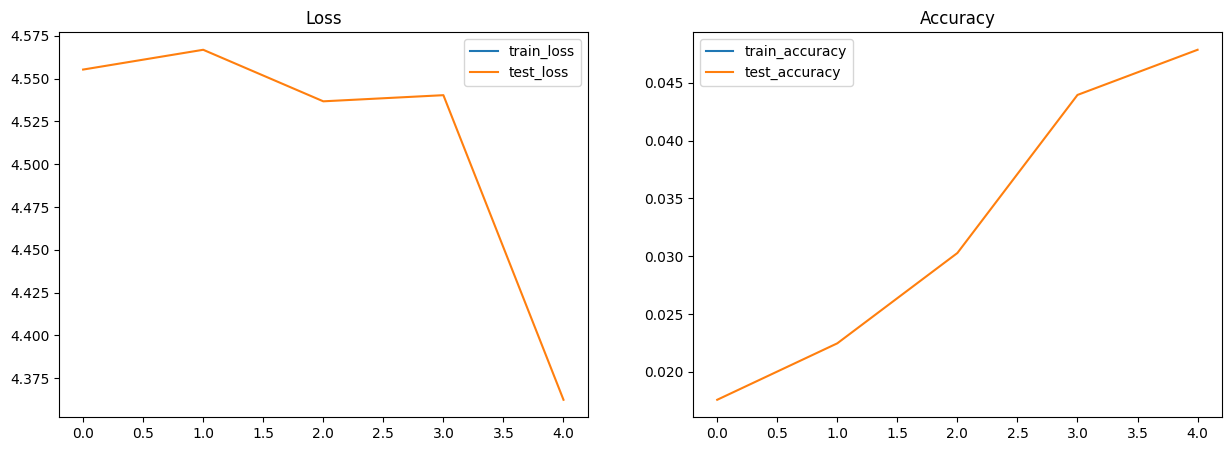

<Figure size 640x480 with 0 Axes>

In [33]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train','test'):
    ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
    ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()
plt.clf()

In [34]:
metrics_history

{'train_loss': [Array(nan, dtype=float32),
  Array(nan, dtype=float32),
  Array(nan, dtype=float32),
  Array(nan, dtype=float32),
  Array(nan, dtype=float32)],
 'train_accuracy': [Array(nan, dtype=float32),
  Array(nan, dtype=float32),
  Array(nan, dtype=float32),
  Array(nan, dtype=float32),
  Array(nan, dtype=float32)],
 'test_loss': [Array(4.555341, dtype=float32),
  Array(4.566901, dtype=float32),
  Array(4.5367823, dtype=float32),
  Array(4.54037, dtype=float32),
  Array(4.362379, dtype=float32)],
 'test_accuracy': [Array(0.01757812, dtype=float32),
  Array(0.02246094, dtype=float32),
  Array(0.03027344, dtype=float32),
  Array(0.04394531, dtype=float32),
  Array(0.04785156, dtype=float32)]}

In [35]:
keyz = jax.random.PRNGKey(41)
print(0, keyz)
for i in range(10):
    keyz = (jax.random.split(keyz)[0])
    print(i+1, keyz)

0 [ 0 41]
1 [2477087706  579886498]
2 [1637630825 3637391777]
3 [3489662935 3427208689]
4 [ 194212661 3136053954]
5 [2271129502  797301296]
6 [3105230869 2603740948]
7 [3072571174  548896694]
8 [ 704227404 2415736319]
9 [4106711292  325946573]
10 [ 638213751 2812659222]


In [36]:
metric

'loss'